# Загрузка библиотек

In [144]:
! pip install -q opendatasets pandas numpy kaggle tensorflow matplotlib scikit-learn

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import PIL
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, EfficientNetB0

from sklearn.model_selection import train_test_split

# Для запуска в google collab

In [147]:
import os
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

import tensorflow as tf

print(tf.test.gpu_device_name())

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
! kaggle competitions download -c dl-captcha-new

! unzip -o "dl-captcha-new.zip"

# Загрузка данных

In [159]:
BASE_PATH = 'mds-misis-dl-captchan/'
images_train = np.load(f'{BASE_PATH}images.npy')
labels_train = np.load(f'{BASE_PATH}labels.npy')

images_test = np.load(f'{BASE_PATH}images_sub.npy')

In [161]:
print(f"Размер тренировочных images и labels к нему: {images_train.shape}; {labels_train.shape}")
print(f"Мин-макс таргеты: {labels_train.min()} - {labels_train.max()}")
print(f"Размер тестовых images, которые надо классифицировать {images_test.shape}")

Размер тренировочных images и labels к нему: (20000, 48, 48, 3); (20000,)
Мин-макс таргеты: 0 - 25
Размер тестовых images, которые надо классифицировать (50000, 48, 48, 3)


In [163]:
sample_submission_df = pd.read_csv(f'{BASE_PATH}sample_submission.csv')
print("Ожидаемый формат submission:")
sample_submission_df.head()

Ожидаемый формат submission:


,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


# Предобработка данных

In [165]:
print(f"В данных images_train NaN значения: {np.isnan(images_train).any()}")
print(f"В данных labels_train NaN значения: {np.isnan(labels_train).any()}")
print(f"В данных images_test NaN значения: {np.isnan(images_test).any()}")

В данных images_train NaN значения: False
В данных labels_train NaN значения: False
В данных images_test NaN значения: False


# Setup

In [167]:
EPOCHS_COUNT         = 80
BATCH_SIZE           = 200
LR                   = 1e-4
VAL_SPLIT            = 0.3

CLASS_NUM            = 26
IMG_SIZE             = 48
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

# Пример картинок

In [ ]:
print('Пример картинок:')
random_integers = [random.randint(0, 19999) for _ in range(12)]

plt.figure(figsize=(12,8))
for i, index in enumerate(random_integers):
    im = PIL.Image.fromarray(images_train[index])
    label = labels_train[index]
    letter = chr(label + ord('A'))

    plt.subplot(3, 4, i + 1)
    plt.imshow(im)
    plt.title(f'Class: {label}({letter})')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Stratify split

In [169]:
X_train, X_test, y_train, y_test = \
    train_test_split(images_train, labels_train, test_size=VAL_SPLIT, random_state=RANDOM_SEED, stratify=labels_train)

X_train.shape, X_test.shape

((14000, 48, 48, 3), (6000, 48, 48, 3))

In [171]:
unique_values_train, counts_train = np.unique(y_train, return_counts=True)
unique_values_test, counts_test = np.unique(y_test, return_counts=True)
len(unique_values_train), len(unique_values_test)

(26, 26)

In [173]:
y_train = to_categorical(y_train, num_classes=CLASS_NUM)
y_test = to_categorical(y_test, num_classes=CLASS_NUM)

# Data augmentation

In [175]:
def get_train_datagen():
  return ImageDataGenerator(
      rescale=1. / 255,
      # shear_range=0.2,
      # zoom_range=[0.25,0.5],
      # brightness_range=[0.5, 1.5],
      width_shift_range=0.1,
      height_shift_range=0.1,
  )

def get_test_datagen():
  return ImageDataGenerator(rescale=1. / 255)

In [177]:
train_datagen = get_train_datagen()
test_datagen = get_test_datagen()

# Data generator

In [180]:
def get_train_generator(train_datagen, X_train, y_train):
  return train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED
  )

def get_test_generator(test_datagen, X_test, y_test):
  return test_datagen.flow(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED
  )

In [182]:
train_generator = get_train_generator(train_datagen, X_train, y_train)
test_generator = get_test_generator(test_datagen, X_test, y_test)

Пример картинок из train_generator:


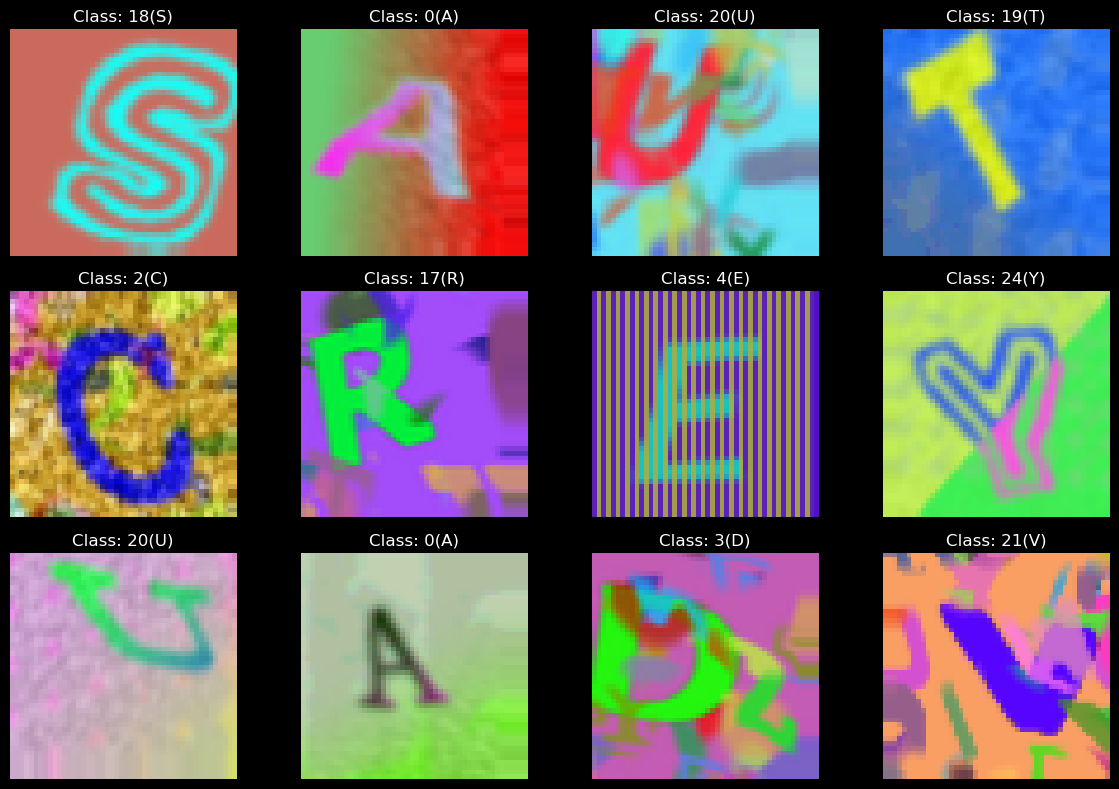

In [184]:
print('Пример картинок из train_generator:')

x, y = next(train_generator)
decoded_y = np.argmax(y, axis=1)
plt.figure(figsize=(12,8))
for i in range(min(12, BATCH_SIZE)):
    im = x[i]
    label = decoded_y[i]
    letter = chr(label + ord('A'))

    plt.subplot(3, 4, i + 1)
    plt.imshow(im)
    plt.title(f'Class: {label}({letter})')
    plt.axis('off')
plt.tight_layout()
plt.show()

Пример картинок из test_generator:


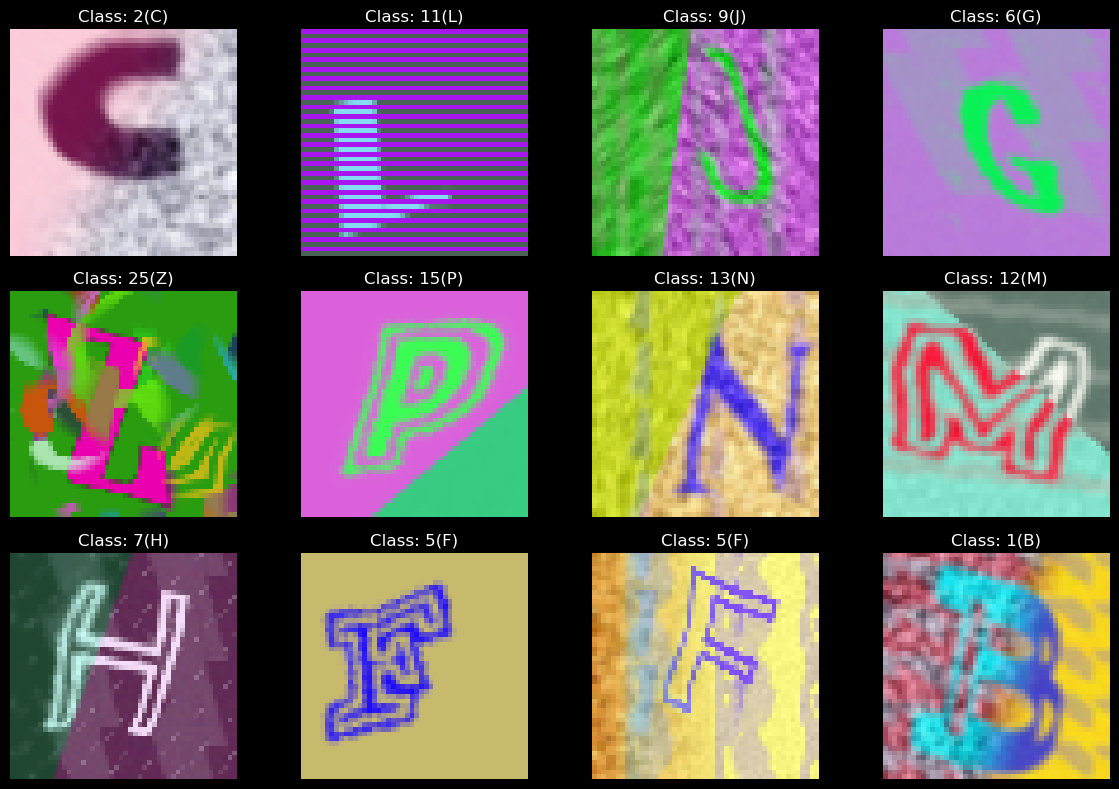

In [186]:
print('Пример картинок из test_generator:')

x, y = next(test_generator)
decoded_y = np.argmax(y, axis=1)
plt.figure(figsize=(12,8))
for i in range(min(12, BATCH_SIZE)):
    im = x[i]
    label = decoded_y[i]
    letter = chr(label + ord('A'))

    plt.subplot(3, 4, i + 1)
    plt.imshow(im)
    plt.title(f'Class: {label}({letter})')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Сборка модели

In [188]:
def create_model():
  base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

  model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=CLASS_NUM, activation='softmax')
    ])

  # optimizer = SGD(learning_rate=LR, momentum=0.9)
  optimizer = Nadam(learning_rate=LR)
  # optimizer = Adam(learning_rate=LR)
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
      
  return model

In [190]:
train_model = create_model()
train_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,851,645 (18.51 MB)

 Trainable params: 4,805,526 (18.33 MB)

 Non-trainable params: 46,119 (180.16 KB)

In [192]:
import time

def save_model(model):
    model.save(f'frozen_bn_model_{time.time()}.keras')

In [194]:
def get_callbacks_list(model_name):
  checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  return [checkpoint, earlystop]

# Обучение модели

In [196]:
history = train_model.fit(
  train_generator,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_data=test_generator,
  validation_steps=test_generator.n // test_generator.batch_size,
  epochs=EPOCHS_COUNT,
  callbacks=get_callbacks_list('best_model_train.keras')
)

Epoch 1/80


/Users/v.papadyk/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.0441 - loss: 4.7101
Epoch 1: val_accuracy improved from -inf to 0.05083, saving model to best_model_train.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 379ms/step - accuracy: 0.0441 - loss: 4.7095 - val_accuracy: 0.0508 - val_loss: 3.2895
Epoch 2/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.0525 - loss: 4.4317
Epoch 2: val_accuracy did not improve from 0.05083
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0525 - loss: 4.4307 - val_accuracy: 0.0438 - val_loss: 3.3170
Epoch 3/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.0658 - loss: 4.1088
Epoch 3: val_accuracy did not improve from 0.05083
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 381ms/step - accuracy: 0.0658 - loss: 4.1076 - val_accuracy: 0.0427 - val_loss: 3.3806
Epoch 4/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.0859 - loss: 3.8474
Epoch 4: val_accuracy did not improve from 0.05083
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step - accuracy: 0.0860 - loss:

In [197]:
train_model.load_weights('best_model_train.keras')

In [198]:
scores = train_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8716 - loss: 0.5120
Accuracy: 87.22%


In [199]:
predictions = train_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
print(f'min: {predicted_classes.min()}, max: {predicted_classes.max()}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
min: 0, max: 25


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


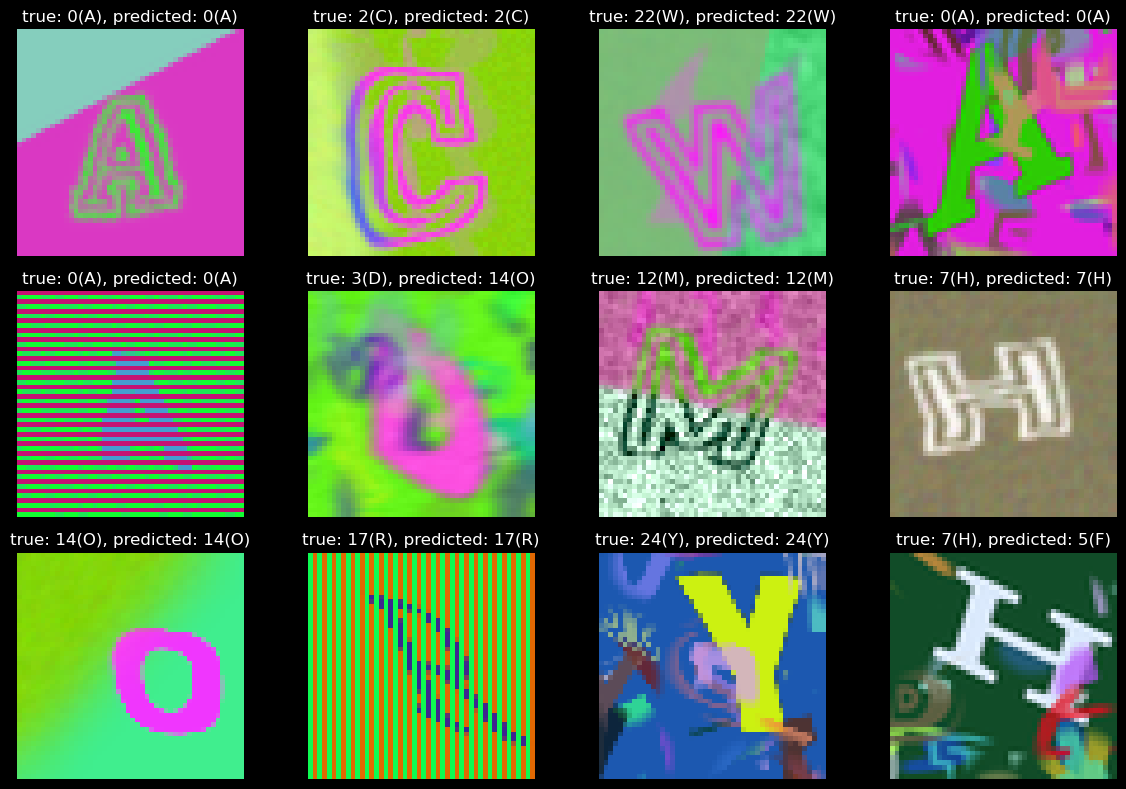

In [200]:
x, y = next(test_generator)
decoded_y = np.argmax(y, axis=1)

predictions = train_model.predict(x)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(12,8))
for i in range(min(12, BATCH_SIZE)):
    im = x[i]
    label_true = decoded_y[i]
    letter_true = chr(label_true + ord('A'))
    label = predicted_classes[i]
    letter = chr(label + ord('A'))

    plt.subplot(3, 4, i + 1)
    plt.imshow(im)
    plt.title(f'true: {label_true}({letter_true}), predicted: {label}({letter})')
    plt.axis('off')
plt.tight_layout()
plt.show()

Сохраним модель

In [201]:
save_model(train_model)

# Визуализация обучения модели

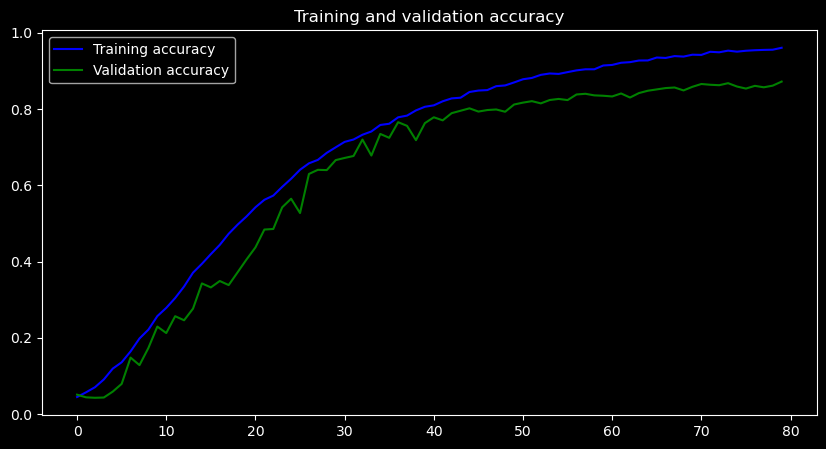

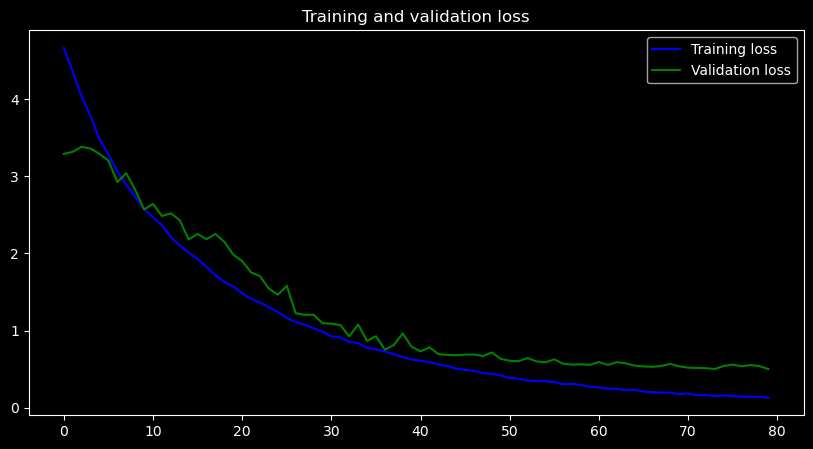

In [208]:
plt.style.use(['dark_background'])

def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Доступ к данным истории через атрибут history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# Обучение модели на всей обучающей выборке

После того, как мы убеделись в правильной работе модели на тренировочных данных нужно переобучить модель на всем тренировочном датасете, чтобы улучшить точность

In [210]:
train_datagen = get_train_datagen()
train_generator = get_train_generator(
    train_datagen,
    images_train,
    to_categorical(labels_train, num_classes=CLASS_NUM),
)

test_model = create_model()

In [212]:
history = test_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_COUNT,
    callbacks=get_callbacks_list('best_model_prod.keras')
)

Epoch 1/80


/Users/v.papadyk/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.0443 - loss: 4.6820

/Users/v.papadyk/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 338ms/step - accuracy: 0.0444 - loss: 4.6807
Epoch 2/80


/Users/v.papadyk/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - accuracy: 0.0672 - loss: 4.2430
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 355ms/step - accuracy: 0.0954 - loss: 3.7763
Epoch 4/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - accuracy: 0.1248 - loss: 3.4401
Epoch 5/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 0.1537 - loss: 3.1376
Epoch 6/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 438ms/step - accuracy: 0.2034 - loss: 2.8639
Epoch 7/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.2415 - loss: 2.6312
Epoch 8/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 358ms/step - accuracy: 0.2990 - loss: 2.3885
Epoch 9/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - accuracy: 0.3356 - loss: 2.2343
Epoch 10/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.3796 - loss: 2.0506
Epoch 11/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.5006 - loss: 1.6208
Epoch 14/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - accuracy: 0.5375 - loss: 1.4944
Epoch 15/80
100/100 ━━━━━━━━━

In [213]:
test_model.load_weights('best_model_prod.keras')

# Предсказания

In [214]:
predictions = test_model.predict(images_test / 255.0)
predicted_classes = np.argmax(predictions, axis=1)
print(f'min: {predicted_classes.min()}, max: {predicted_classes.max()}')

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step
min: 0, max: 25


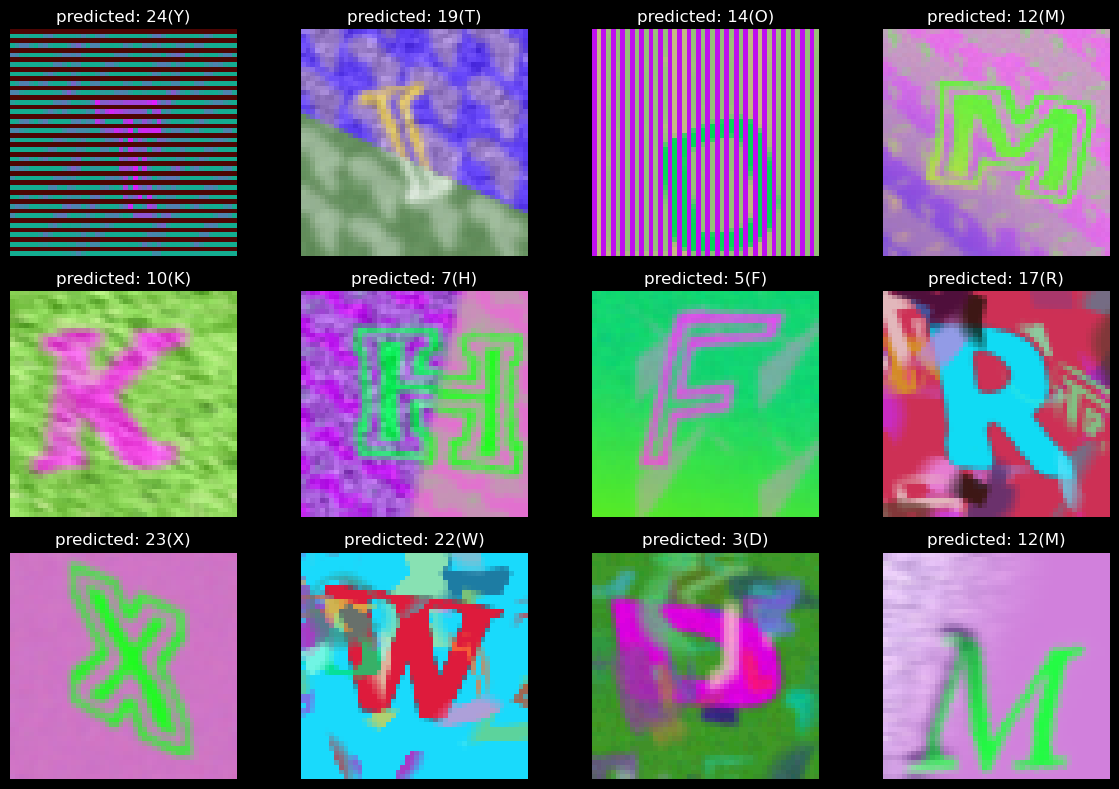

In [215]:
plt.figure(figsize=(12,8))
for i in range(0, 12):
    im = PIL.Image.fromarray(images_test[i])
    label = predicted_classes[i]
    letter = chr(label + ord('A'))

    plt.subplot(3, 4, i + 1)
    plt.imshow(im)
    plt.title(f'predicted: {label}({letter})')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [226]:
save_model(test_model)

# Оформление submission.csv

In [228]:
submition = pd.DataFrame(predicted_classes, columns=['Category'])
submition.index.name = 'Id'
submition.head()

,Category
Id,
0,24
1,19
2,14
3,12
4,10


In [230]:
submition = submition.reset_index()
submition.to_csv('local-submition.csv', index=False);

In [52]:
!kaggle competitions submit dl-captcha-new -f submition.csv -m "auto submission"

100% 410k/410k [00:00<00:00, 708kB/s]
Successfully submitted to DL_CAPTCHA_NEW